In [1]:
import json
import requests
import geopandas as gpd
from shapely.geometry import shape
import io
import os

import numpy as np
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import pandas as pd
from pandas import DataFrame

import matplotlib.pylab as plt

%matplotlib inline

import urllib.request
import gzip
import pylab as pl

import shapely
from shapely.geometry import Point
from fiona.crs import from_epsg
from geopandas.tools import sjoin
import pysal as ps

In [2]:
r = requests.get("https://data.cityofnewyork.us/resource/ith2-q832.json")
r.raise_for_status()

data = r.json()
for d in data:
    d['the_geom'] = shape(d['the_geom'])

gdf = gpd.GeoDataFrame(data).set_geometry('the_geom')
gdf.head()

,puma,shape_area,shape_leng,the_geom
0,3701,97928517.7258,53227.1444612,(POLYGON ((-73.89641133483133 40.9045045208202...
1,3702,188986042.978,106050.002302,(POLYGON ((-73.8442314689986 40.86942035096838...
2,3703,267013740.076,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,106212853.306,47970.9012768,(POLYGON ((-73.84792614069238 40.8713422330779...
4,4015,81054382.1573,50007.4154926,(POLYGON ((-73.95374853778468 40.6385863375854...


In [3]:
gdf.crs

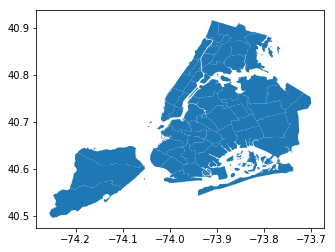

In [4]:

gdf.plot()

#### fig.1: Map of Public Use Microdata Areas(PUMA) boundaries in New York City

In [5]:
#import choroplethNYC as cp
#cp.choroplethNYC(gdf, column=None, color="white", edgecolor="black", lw=2);

In [6]:
myAPI = 'd05dbe918898afad682cdeed2c85afac715014a1'
#from censusAPI.py import myAPI

In [7]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [8]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [9]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [10]:
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [11]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [12]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()


,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [13]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()


,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']
pumaBB['pcBB'] = (pumaBB['B28002_004E']/pumaPP['B28002_001E'])*100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


In [15]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6


In [16]:
bbpc_new = bbpc.drop(bbpc.index[[0]])
bbpc_new.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [17]:
gid = bbpc_new['GCT_STUB.target-geo-id2'].astype(int)

In [18]:
bbpc_new["gid"] = gid - 3600000
bbpc_new.drop(['GCT_STUB.target-geo-id2'], axis=1)

,HC01,HC02,gid
1,81.7,0.2,-3599964
2,80.6,2.6,100
3,75.7,2.2,200
4,79.8,2.6,300
5,81.4,2.4,401
6,78.2,2.3,402
7,76.6,2.2,403
8,81.4,2.1,500
9,84.4,2.3,600
10,67.0,3.0,701


In [19]:
diff_ = pumaBB.merge(bbpc_new, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]
diff_.head()

,pcBB,HC01
0,80.552879,80.6
1,75.733321,75.7
2,79.842678,79.8
3,81.433409,81.4
4,78.150656,78.2


In [20]:
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


#### As shown above, the difference is very small.

In [21]:
if type(gdf['puma'][9]) == str:
    gdf['puma'] = gdf['puma'].astype(int)
print(type(gdf['puma'][9]))

<class 'numpy.int64'>


In [22]:
gdfbb = gdf.merge(pumaBB, left_on='puma', right_on='public use microdata area')


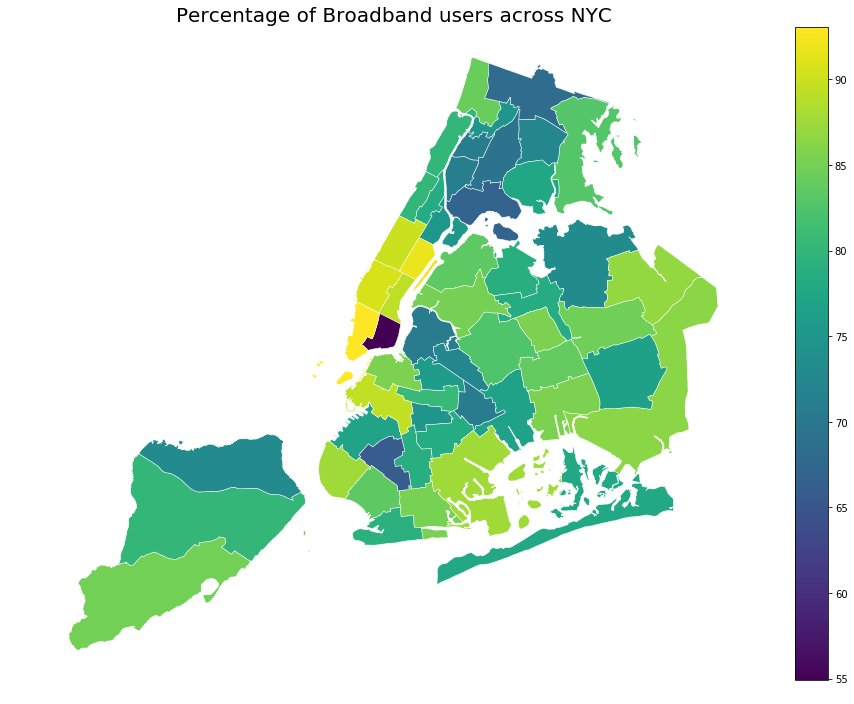

In [23]:
ax = pl.figure(figsize=(16, 12)).add_subplot(111)
gdfbb.plot(ax=ax,column='pcBB', cmap='viridis', legend=True, edgecolor='w', lw=0.5)
ax.set_title('Percentage of Broadband users across NYC',size=20)
ax.axis('off');

#### fig. 2: Percentage of Broadband users across NYC

In [24]:
url = 'https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv'
linkNYC = pd.read_csv(url).drop('Unnamed: 0', axis=1)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [25]:
linkNYC.shape

(1414, 4)

In [26]:
linkNYC.loc[:,"lonlat"] = "(" + linkNYC["longitude"].map(str) + "," + " " + linkNYC["latitude"].map(str) + ")"
linkNYC.loc[:,"lonlat"] = linkNYC.loc[:,"lonlat"].map(eval)


In [27]:
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC = gpd.GeoDataFrame(linkNYC, geometry="geometry")
linkNYC.crs = {'init': 'epsg:4326'}

linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.94223923850001, 40.701930343899996)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


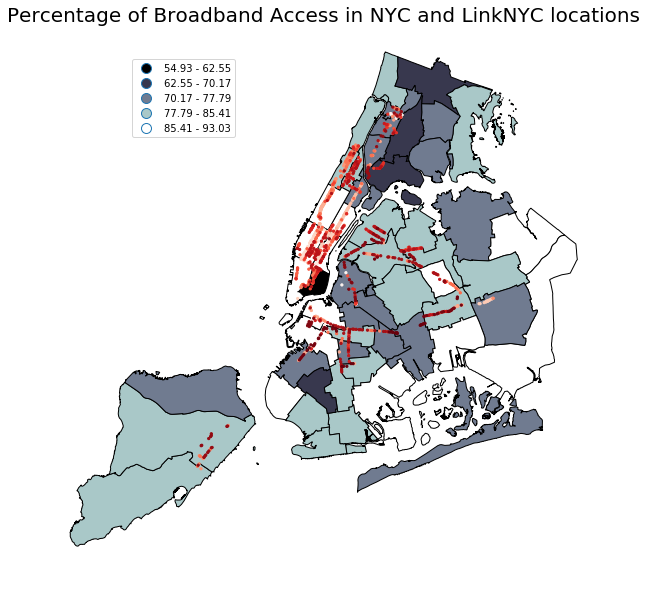

In [28]:
ax = pl.figure(figsize=(10, 10)).add_subplot(111)
gdfbb.plot(ax=ax,column='pcBB',scheme='Equal_interval', k=5, cmap='bone', 
                    edgecolor='k', legend=True, lw=1)
linkNYC.plot(ax=ax, c=linkNYC.date_link_, cmap='Reds', markersize=5)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax.set_title('Percentage of Broadband Access in NYC and LinkNYC locations', fontsize=20)
ax.axis('off');

#### fig.3: Percentage of Broadband Access in NYC and LinkNYC locations

In [29]:
keyPop = 'B00001_001E'
aff1y['variables'][keyPop]

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [30]:
pumashppop = gdf.merge(pumaPop, left_on='puma', right_on='public use microdata area')
pumashppop.head()

,puma,shape_area,shape_leng,the_geom,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701,97928517.7258,53227.1444612,(POLYGON ((-73.89641133483133 40.9045045208202...,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,188986042.978,106050.002302,(POLYGON ((-73.8442314689986 40.86942035096838...,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,267013740.076,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,106212853.306,47970.9012768,(POLYGON ((-73.84792614069238 40.8713422330779...,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,81054382.1573,50007.4154926,(POLYGON ((-73.95374853778468 40.6385863375854...,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


In [31]:
gpd.crs = pumashppop.crs 

In [32]:
linkpp= gpd.sjoin(pumashppop,linkNYC, how='left')
linkpp = linkpp.groupby('puma')['link_site'].count().reset_index()

In [33]:
linkpp.head()

,puma,link_site
0,3701,1
1,3702,0
2,3703,0
3,3704,0
4,3705,1


In [34]:
pumashplc = pumashppop.merge(linkpp, on='puma')

pumashplc['linkNYCp100p'] = (pumashplc['link_site']/(pumashplc['B00001_001E'])*100)
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

In [35]:
pumashplc["linkNYCp100p"][pumashplc["link_site"] != 0].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

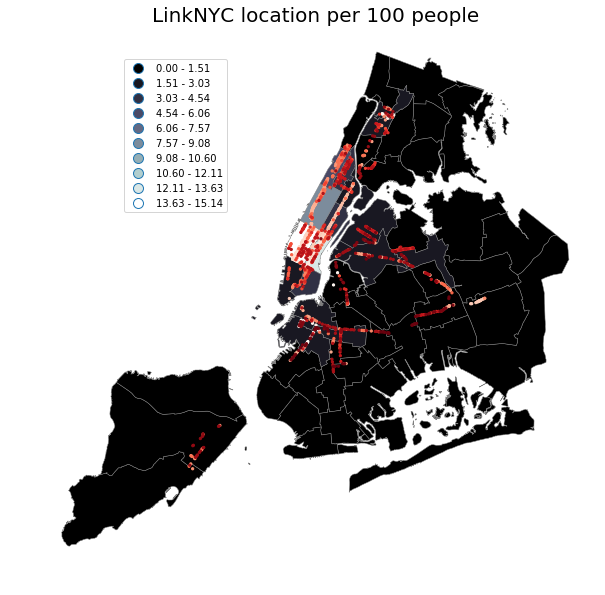

In [36]:

ax = pl.figure(figsize=(10, 10)).add_subplot(111)
# plot the puma, with legend
pumashplc.plot(ax=ax, column='linkNYCp100p', cmap='bone', scheme='Equal_interval', k=10, 
               edgecolor='grey', lw=0.5, legend=True)
# plot linkNYC, without legend
linkNYC.plot(ax=ax, c=linkNYC.date_link_, cmap='Reds', markersize=5)
# relocate legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
ax.set_title('LinkNYC location per 100 people', fontsize=20)
ax.axis('off');

In [37]:
### Extra Credit:

#### The following diagram shows that there are few outliers once the number of stations/100 people exceeds 8 stations

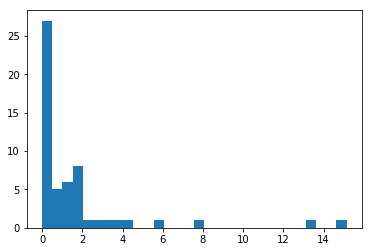

In [38]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);

In [39]:
#### To minimize this error we can truncate values to the 67% quantile, or change the symbology intervals into the following: 
#### 0-2/ 2.1-4.5/ 4.6-8/ 8.1 - max.

In [40]:
import pysal as ps
from pysal.contrib.viz import mapping as maps

ValueError: Length of values does not match length of index

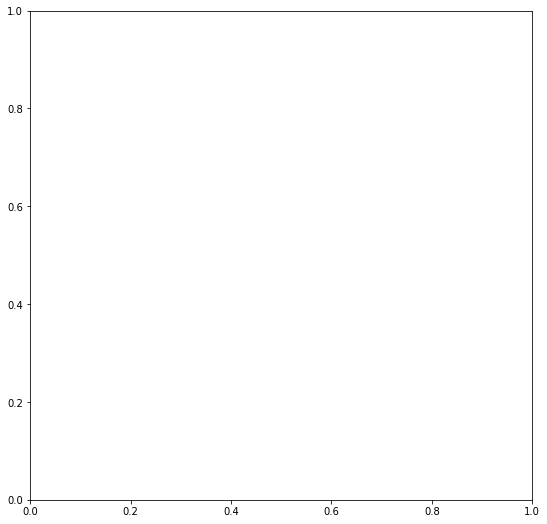

In [41]:
tx = pumashplc
data = ps.Quantiles(pumaPop.B00001_001E, k=1000)
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=data.yb).plot(column='cl', categorical=True, \
        k=1000, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial lag Deciles")
plt.show()